In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa
import imgaug as ia

import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import random
import pickle
import cv2
import os
import argparse
import re

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell #multiple outputs in notebook
InteractiveShell.ast_node_interactivity = "all"            #

In [102]:
dir_dataset = "/Users/annaleid/Documents/Jordy/Cropped Kleur"

In [131]:
# # augmentations
sometimes = lambda aug: iaa.Sometimes(0.4, aug)

# seq = iaa.Sequential([
#         sometimes(iaa.OneOf([
#             iaa.DirectedEdgeDetect(alpha=(0.1, 0.8), direction=(0.0, 1.0)),
#             iaa.Add((-150, 150), per_channel=0.5),
#             iaa.AddElementwise((-50, 50), per_channel=0.5),
#             iaa.Invert(0.25),
#             iaa.Multiply((0.8, 1.2), per_channel=0.2)
#             ])),
#         sometimes(iaa.Affine(
#             scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#             rotate=(-5, 5),
#             shear=(-2, 2))
#             ),
#         iaa.SomeOf((2,3), [
#             iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)),
#             iaa.Sharpen(alpha=(0, 0.8), lightness=(0.75, 1.5)),
#             iaa.ContrastNormalization((0.75, 1.25), per_channel = 0.5),
#             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
#             iaa.SaltAndPepper(p=(0, 0.1))
#             ]),
    
#     iaa.SomeOf((0, 3), [
#                 iaa.OneOf([
#                     iaa.GaussianBlur((0, 2.0)),
#                     iaa.AverageBlur(k=(2, 5)),
#                     iaa.MedianBlur(k=(3, 5)),
#                 ]),

#                 iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
#                 iaa.Emboss(alpha=(0, 0.7), strength=(0, 1.0)),

#                 sometimes(iaa.OneOf([
#                     iaa.EdgeDetect(alpha=(0, 0.7)),
#                     iaa.DirectedEdgeDetect(
#                         alpha=(0, 0.7), direction=(0.0, 1.0)
#                     ),
#                 ])),

#                 iaa.AdditiveGaussianNoise(
#                     loc=0, scale=(0.0, 0.05*255), per_channel=0.5
#                 ),

#                 iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5),
#                 iaa.AveragePooling([2, 3])
#     ])

# ], random_order = True)


seq = iaa.Sequential([
        sometimes(iaa.OneOf([
            iaa.DirectedEdgeDetect(alpha=(0.1, 0.8), direction=(0.0, 1.0)),
            iaa.Add((-150, 150), per_channel=0.5),
            iaa.Invert(0.25),
            iaa.Multiply((0.8, 1.2), per_channel=0.2)
            ])),
        sometimes(iaa.Affine(
            scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
            translate_percent={"x": (-0.15, 0.15), "y": (-0.1, 0.1)},
            rotate=(-5, 5),
            shear=(-2, 2))
            ),
        iaa.SomeOf((2,3), [
            iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)),
            iaa.Sharpen(alpha=(0, 0.8), lightness=(0.80, 1.3)),
            iaa.ContrastNormalization((0.80, 1.20), per_channel = 0.5),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            iaa.SaltAndPepper(p=(0, 0.1)),
            iaa.ImpulseNoise(0.1)
            ]),
], random_order = True)

In [132]:
import os
from glob import glob
from datetime import datetime
from shutil import copyfile
 
import imgaug as ia
from imgaug import augmenters as iaa
# adjusted code from https://snow.dog/blog/data-augmentation-for-small-datasets
  
INPUT = "/Users/annaleid/Documents/Jordy/test_aug"
OUTPUT = "/Users/annaleid/Documents/Jordy/test_aug/notes_aug"
WHITE_LIST_FORMAT = ('png', 'jpg', 'jpeg', 'bmp', 'ppm', 'JPG')
ITERATIONS = 75
 
def check_dir_or_create(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
 
files = [y for x in os.walk(INPUT) for y in glob(os.path.join(x[0], '*')) if os.path.isfile(y)]
train_files = [f for f in files if f.endswith(WHITE_LIST_FORMAT)]
classes = [os.path.basename(os.path.dirname(x)) for x in files]
classes_set = set(classes)
for _class in classes_set:
    _dir = os.path.join(OUTPUT, _class)
    check_dir_or_create(_dir)
 
batches = []
BATCH_SIZE = 30
batches_count = len(files) // BATCH_SIZE + 1
for i in range(batches_count):
    batches.append(train_files[BATCH_SIZE * i:BATCH_SIZE * (i + 1)])
 
images = []
for i in range(ITERATIONS):
    print(i, datetime.time(datetime.now()))
    for batch in batches:
        images = []
        for file in batch:
            img = cv2.imread(file)
            images.append(img)
        images_aug = seq.augment_images(images)
        for file, image_aug in zip(batch, images_aug):
            root, ext = os.path.splitext(file)
            new_filename = root + '_{}'.format(i) + ext
            new_path = new_filename.replace(INPUT, OUTPUT, 1)
                        
            plt.imsave(new_path, image_aug)
 

0 10:56:40.012481
1 10:56:40.063669
2 10:56:40.093060
3 10:56:40.124771
4 10:56:40.162771
5 10:56:40.193724
6 10:56:40.226939
7 10:56:40.255850
8 10:56:40.285208
9 10:56:40.317771
10 10:56:40.350789
11 10:56:40.384079
12 10:56:40.417187
13 10:56:40.442345
14 10:56:40.467823
15 10:56:40.495868
16 10:56:40.525407
17 10:56:40.556260
18 10:56:40.587267
19 10:56:40.621935
20 10:56:40.663308
21 10:56:40.694434
22 10:56:40.732629
23 10:56:40.764785
24 10:56:40.799321
25 10:56:40.830042
26 10:56:40.860686
27 10:56:40.899846
28 10:56:40.939796
29 10:56:40.963379
30 10:56:40.993386
31 10:56:41.026680
32 10:56:41.050114
33 10:56:41.081846
34 10:56:41.118838
35 10:56:41.145558
36 10:56:41.178658
37 10:56:41.212612
38 10:56:41.239653
39 10:56:41.272823
40 10:56:41.304921
41 10:56:41.340218
42 10:56:41.369191
43 10:56:41.399593
44 10:56:41.432945
45 10:56:41.463759
46 10:56:41.496582
47 10:56:41.532871
48 10:56:41.571074
49 10:56:41.598386
50 10:56:41.636104
51 10:56:41.667249
52 10:56:41.700824
53 

In [41]:
##### Create list with arrays and labels of images

# initialize image dimensions
IMAGE_DIMS = (158, 100, 1)

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(OUTPUT)))
random.seed(42)
random.shuffle(imagePaths)

# initialize the data and labels
images = []
data = []
noteLabels = []
durationLabels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
#     image = cv2.imread(imagePath)
    image = tf.keras.preprocessing.image.load_img(imagePath, color_mode = 'grayscale', target_size = [158,100])
#     image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0])) # otherwise error in next cell
    image = img_to_array(image)
    data.append(image)
    images.append(image)
    
    # extract set of class labels from the image path and update the labels
    # update the respective lists
    filename = imagePath.split(os.path.sep)[-1]
    duration = re.search('(breve|longa|maxima|\d\.?)', filename).group()
    note = re.search('([a-z]\'*|^\w{1}\'*)', filename).group()
    noteLabels.append(note)
    durationLabels.append(duration)

In [42]:
set(noteLabels)
set(durationLabels)
len(set(map(len, (data, noteLabels, durationLabels)))) == 1 #check if length of lists is the same

{"a'",
 "a''",
 'b',
 "b'",
 "b''",
 "c'",
 "c''",
 "c'''",
 "d'",
 "d''",
 "e'",
 "e''",
 "f'",
 "f''",
 "g'",
 "g''"}

{'1', '1.', '2', '2.', '4', '4.', 'breve', 'longa', 'maxima'}

True

In [43]:
data = np.array(data) 

# convert the label lists to NumPy arrays prior to binarization
noteLabels = np.array(noteLabels)
durationLabels = np.array(durationLabels)
 
# binarize both sets of labels
noteLB = LabelBinarizer()
durationLB = LabelBinarizer()
noteLabels = noteLB.fit_transform(noteLabels)
durationLabels = durationLB.fit_transform(durationLabels)

trainX, testX, trainNoteY, testNoteY, trainDurationY, testDurationY = train_test_split(data,
                                    noteLabels, durationLabels, random_state=666, train_size=0.8)

In [44]:
trainNoteY.shape
testNoteY.shape
trainDurationY.shape
testDurationY.shape

noteLabels.shape
durationLabels.shape
data.shape
trainX[0].shape

(8640, 16)

(2160, 16)

(8640, 9)

(2160, 9)

(10800, 16)

(10800, 9)

(10800, 158, 100, 1)

(158, 100, 1)

In [71]:
# model

image_dims = (158, 100, 1) #height, width
inputs = Input(shape=(image_dims))
chanDim = -1

# CONV => RELU => POOL
x = Conv2D(32, (5, 5), padding="same", activation = 'relu')(inputs)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2D(32, (5, 5), padding="same", activation = 'relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# CONV => RELU => POOL
x = Conv2D(64, (3, 3), padding="same", activation = 'relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2D(64, (3, 3), padding="same", activation = 'relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# CONV => RELU => POOL
x = Conv2D(128, (3, 3), padding="same", activation = 'relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2D(128, (3, 3), padding="same", activation = 'relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# CONV => RELU => POOL
x = Conv2D(256, (3, 3), padding="same", activation = 'relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# define a branch of output layers for the number of different notes
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
note_output = Dense(len(noteLB.classes_), activation='softmax', name = "note_output")(x)
duration_output = Dense(len(durationLB.classes_), activation='softmax', name = "duration_output")(x)

model = Model(
    inputs=inputs,
    outputs=[note_output, duration_output],
    name="notes_recognition")

In [46]:
model.summary()
model.input_shape
model.output_shape

Model: "notes_recognition"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 158, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 158, 100, 64) 1664        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 158, 100, 64) 256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 79, 50, 64)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________

(None, 158, 100, 1)

[(None, 16), (None, 9)]

In [99]:
epochs = 100
init_lr = 1e-3
batch_size = 64

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "note_output": "categorical_crossentropy",
    "duration_output": "categorical_crossentropy",}
lossWeights = {"note_output": 1.0, "duration_output": 1.0}
 
# initialize the optimizer and compile the model
opt = optimizers.Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [ ]:
# gen = ImageDataGenerator(preprocessing_function=seq.augment_image) 

# def generate_data_generator(generator, X, Y1, Y2, b):
#         genY1 = generator.flow(X, Y1, batch_size=b, seed=7)
#         genY2 = generator.flow(X, Y2, batch_size=b, seed=7)
#         while True:
#             g1 = genY1.next()
#             g2 = genY2.next()
# #             yield {'main_input': g1[0]}, {'note_output': g1[1], 'duration_output': g2[1]}
#             yield g1[0], [g1[1], g2[1]]

In [56]:
# callbacks
early_stopping = EarlyStopping(monitor='val_note_output_accuracy', patience=10, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              min_lr=0.00001)

checkpoint = ModelCheckpoint("/Users/annaleid/Documents/Jordy/Trained Models/",
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq=1)

In [60]:
# train the network to perform multi-output classification
H = model.fit(trainX, {"note_output": trainNoteY, "duration_output": trainDurationY},
    validation_data=(testX, {"note_output": testNoteY, "duration_output": testDurationY}),
    epochs=epochs,
    verbose=1,
    callbacks = [reduce_lr, early_stopping])

# H = model.fit_generator(
#             generate_data_generator(gen, trainX, trainNoteY, trainDurationY, b=batch_size),
#             validation_data=(
#             testX, [testNoteY, testDurationY]),
#             steps_per_epoch=len(trainX)//batch_size, epochs=epochs,
#             verbose=1,
#             callbacks = [reduce_lr])

Train on 8640 samples, validate on 2160 samples
Epoch 1/100
8640/8640 [==============================] - 175s 20ms/sample - loss: 5.0601 - note_output_loss: 2.5828 - duration_output_loss: 2.4772 - note_output_accuracy: 0.2487 - duration_output_accuracy: 0.2139 - val_loss: 2.9742 - val_note_output_loss: 1.4145 - val_duration_output_loss: 1.5589 - val_note_output_accuracy: 0.4852 - val_duration_output_accuracy: 0.3894
Epoch 2/100
8640/8640 [==============================] - 174s 20ms/sample - loss: 3.4657 - note_output_loss: 1.6926 - duration_output_loss: 1.7731 - note_output_accuracy: 0.4282 - duration_output_accuracy: 0.3453 - val_loss: 2.2635 - val_note_output_loss: 1.0840 - val_duration_output_loss: 1.1798 - val_note_output_accuracy: 0.6241 - val_duration_output_accuracy: 0.5139
Epoch 3/100
8640/8640 [==============================] - 174s 20ms/sample - loss: 2.9681 - note_output_loss: 1.4515 - duration_output_loss: 1.5166 - note_output_accuracy: 0.5017 - duration_output_accuracy: 0.

Epoch 23/100
8640/8640 [==============================] - 184s 21ms/sample - loss: 0.2639 - note_output_loss: 0.1343 - duration_output_loss: 0.1295 - note_output_accuracy: 0.9623 - duration_output_accuracy: 0.9580 - val_loss: 0.2542 - val_note_output_loss: 0.1528 - val_duration_output_loss: 0.0996 - val_note_output_accuracy: 0.9537 - val_duration_output_accuracy: 0.9676
Epoch 24/100
8640/8640 [==============================] - 184s 21ms/sample - loss: 0.2546 - note_output_loss: 0.1243 - duration_output_loss: 0.1302 - note_output_accuracy: 0.9623 - duration_output_accuracy: 0.9596 - val_loss: 0.2436 - val_note_output_loss: 0.1498 - val_duration_output_loss: 0.0921 - val_note_output_accuracy: 0.9611 - val_duration_output_accuracy: 0.9685
Epoch 25/100
8640/8640 [==============================] - 183s 21ms/sample - loss: 0.2473 - note_output_loss: 0.1300 - duration_output_loss: 0.1173 - note_output_accuracy: 0.9627 - duration_output_accuracy: 0.9622 - val_loss: 0.2572 - val_note_output_los

Epoch 45/100
8640/8640 [==============================] - 187s 22ms/sample - loss: 0.0626 - note_output_loss: 0.0346 - duration_output_loss: 0.0280 - note_output_accuracy: 0.9913 - duration_output_accuracy: 0.9907 - val_loss: 0.1938 - val_note_output_loss: 0.0957 - val_duration_output_loss: 0.0967 - val_note_output_accuracy: 0.9759 - val_duration_output_accuracy: 0.9745
Epoch 46/100
8640/8640 [==============================] - 182s 21ms/sample - loss: 0.0496 - note_output_loss: 0.0238 - duration_output_loss: 0.0258 - note_output_accuracy: 0.9934 - duration_output_accuracy: 0.9924 - val_loss: 0.1929 - val_note_output_loss: 0.0941 - val_duration_output_loss: 0.0973 - val_note_output_accuracy: 0.9745 - val_duration_output_accuracy: 0.9741
Epoch 47/100
8640/8640 [==============================] - 183s 21ms/sample - loss: 0.0515 - note_output_loss: 0.0219 - duration_output_loss: 0.0296 - note_output_accuracy: 0.9935 - duration_output_accuracy: 0.9903 - val_loss: 0.1988 - val_note_output_los

Text(0.5, 1.0, 'Total loss')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss for note_output_loss')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss for duration_output_loss')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss')

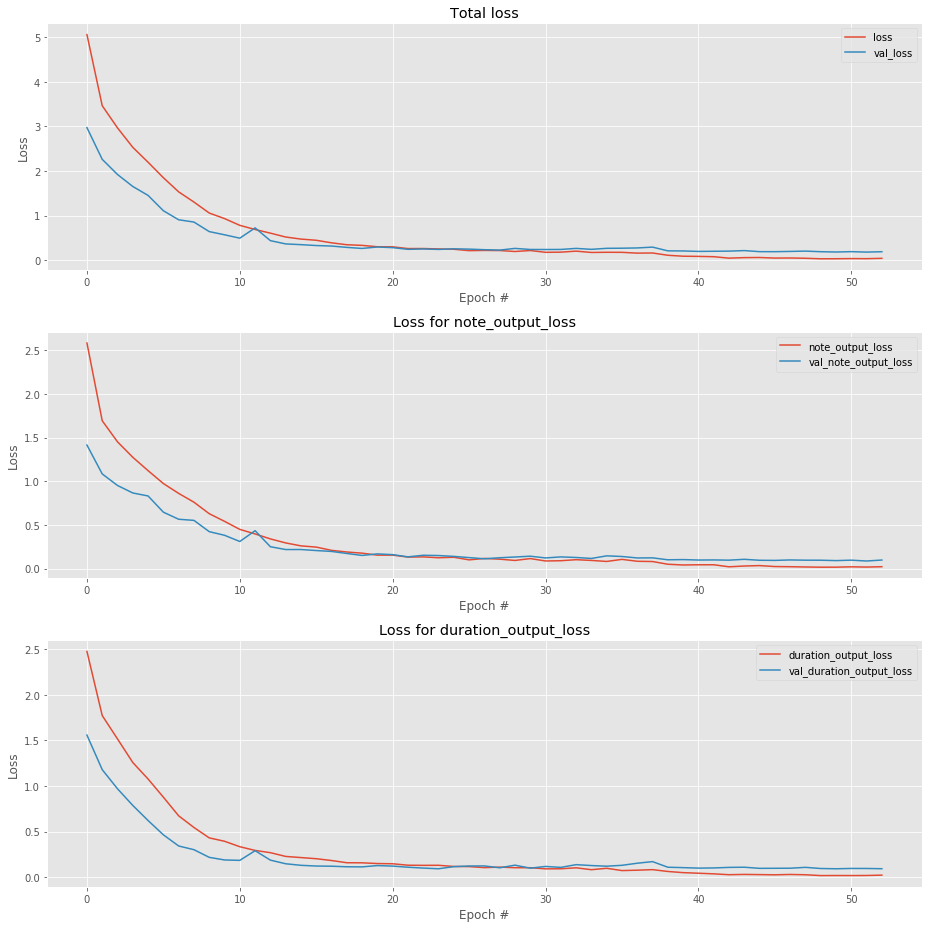

In [63]:
# plot the total loss, category loss, and color loss
lossNames = ["loss", "note_output_loss", "duration_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
 
# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, 53), H.history[l], label=l)
    ax[i].plot(np.arange(0, 53), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
 
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

Text(0.5, 1.0, 'Accuracy for note_output_accuracy')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy for duration_output_accuracy')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Accuracy')

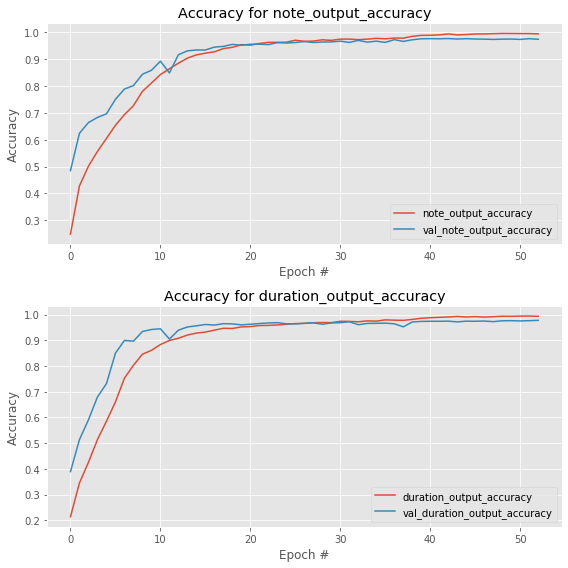

In [64]:
# create a new figure for the accuracies
accuracyNames = ["note_output_accuracy", "duration_output_accuracy"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
 
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, 53), H.history[l], label=l)
    ax[i].plot(np.arange(0, 53), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
 
# save the accuracies figure
plt.tight_layout()

<Figure size 2160x720 with 0 Axes>

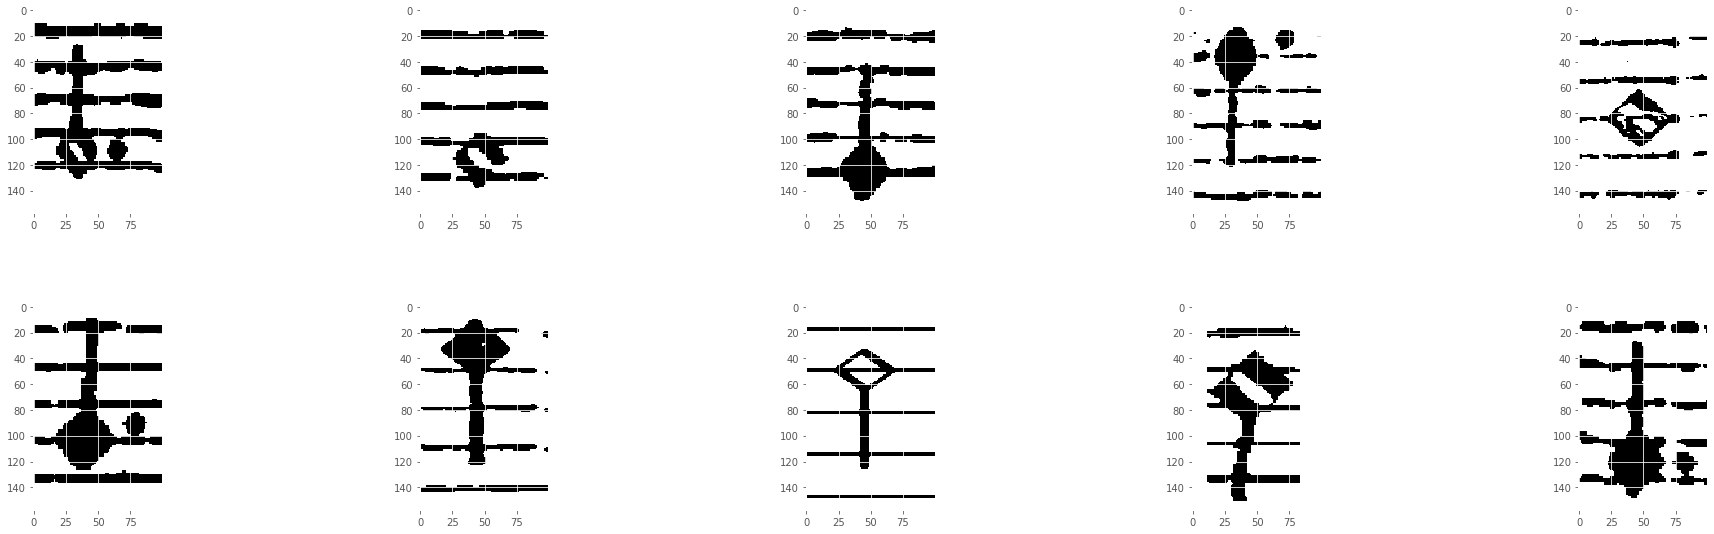

In [65]:
IMAGE_DIMS = (158, 100, 1)
plt.figure(figsize=[30,10]) # set image size
plt.subplots_adjust(wspace = 2)# set distance between the subplots

folder = "/Users/annaleid/Documents/Jordy/test images/"
images = os.listdir(folder)
i = 0

for image in images[:10]:
    plt.subplot(2,5,i+1)
    picture = cv2.imread(folder+image, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(picture, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    ret1, th1 = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    imgplot = plt.imshow(th1, cmap='gray')
    i += 1
    
plt.show()

### Test Images

In [23]:
IMAGE_DIMS = (158, 100, 1)
folder_test = "/Users/annaleid/Documents/Jordy/test images/"

##### Create list with arrays and labels of test images

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(folder_test)))
random.seed(42)
random.shuffle(imagePaths)

# initialize the data and labels
images_test = []
data_test = []
noteLabels_test = []
durationLabels_test = []

# loop over the input images
for imagePath in imagePaths:
    image = tf.keras.preprocessing.image.load_img(imagePath, color_mode = 'grayscale', target_size = [158,100])
    image = img_to_array(image)
    data_test.append(image)
    images_test.append(image)
    
    # extract set of class labels from the image path and update the labels
    # update the respective lists
    filename = imagePath.split(os.path.sep)[-1]
    duration = re.search('(breve|longa|maxima|\d\.?)', filename).group()
    note = re.search('([a-z]\'*|^\w{1}\'*)', filename).group()
    noteLabels_test.append(note)
    durationLabels_test.append(duration)

In [24]:
set(noteLabels_test)
set(durationLabels_test)
len(set(map(len, (data_test, noteLabels_test, durationLabels_test)))) == 1 #check if length of lists is the same

{"a'", "b'", "c''", "d'", "d''", "e'", "e''", "f'", "f''", "g'", "g''"}

{'1', '2', '2.', '4', '4.', 'breve', 'longa'}

True

In [25]:
data_test = np.array(data_test) 

# convert the label lists to NumPy arrays prior to binarization
noteLabels_test = np.array(noteLabels_test)
durationLabels_test = np.array(durationLabels_test)
 
# binarize both sets of labels
noteLabels_test = noteLB.transform(noteLabels_test)
durationLabels_test = durationLB.transform(durationLabels_test)

In [ ]:
data_test.shape
noteLabels_test.shape
durationLabels_test.shape
data_test[0].shape

"c''"

'2'

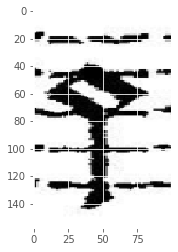

"f'"

'longa'

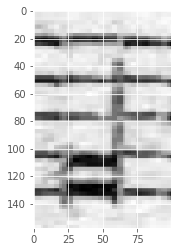

"f'"

'1'

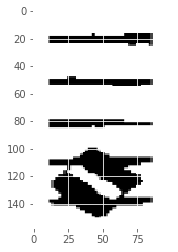

In [29]:
# double check if images are correctly labeled

from PIL import Image
from numpy import *

noteLB.inverse_transform(noteLabels_test)[5]
durationLB.inverse_transform(durationLabels_test)[5]

plt.imshow(np.squeeze(data_test[5]), cmap = 'gray')
plt.show()

noteLB.inverse_transform(noteLabels_test)[10]
durationLB.inverse_transform(durationLabels_test)[10]

plt.imshow(np.squeeze(data_test[10]), cmap = 'gray')
plt.show()

noteLB.inverse_transform(noteLabels_test)[15]
durationLB.inverse_transform(durationLabels_test)[15]

plt.imshow(np.squeeze(data_test[15]), cmap = 'gray')
plt.show()

In [100]:
# classify test images with model
scores = model.evaluate(data_test, [noteLabels_test, durationLabels_test], verbose=0)

# print scores
for i, j in zip(model.metrics_names, scores):
    print(i,'=', j)

loss = 8.671616181083348
note_output_loss = 4.893258
duration_output_loss = 3.8792827
note_output_accuracy = 0.06521739
duration_output_accuracy = 0.1521739


In [98]:
note_true, note_pred
note_pred, duration_pred = model.predict(data_test)
note_true, duration_true = noteLabels_test.argmax(axis=-1), durationLabels_test.argmax(axis=-1)
note_pred, duration_pred = note_pred.argmax(axis=-1), duration_pred.argmax(axis=-1)

(array([ 9,  9, 10,  6,  8,  6, 13, 12,  6,  0, 12,  0, 14, 11,  6, 12, 12,
        14, 14, 13, 12, 11, 11,  9,  8, 15, 14,  0,  9,  9, 14,  6, 12, 14,
         0, 10,  0, 12,  3,  3,  6,  9,  9,  0,  3, 14]),
 array([10, 10, 15, 10, 11, 10, 10, 10, 10, 15, 10, 10, 15, 10, 10, 10, 10,
         0,  0, 10, 10,  0,  0, 10, 10,  0, 10,  0, 10, 10, 10, 10, 10,  0,
         0, 10, 10, 10, 10, 10, 15,  0, 10, 10, 10,  0]))

In [95]:
note_true, note_pred

(array([ 9,  9, 10,  6,  8,  6, 13, 12,  6,  0, 12,  0, 14, 11,  6, 12, 12,
        14, 14, 13, 12, 11, 11,  9,  8, 15, 14,  0,  9,  9, 14,  6, 12, 14,
         0, 10,  0, 12,  3,  3,  6,  9,  9,  0,  3, 14]),
 array([10, 10, 15, 10, 11, 10, 10, 10, 10, 15, 10, 10, 15, 10, 10, 10, 10,
         0,  0, 10, 10,  0,  0, 10, 10,  0, 10,  0, 10, 10, 10, 10, 10,  0,
         0, 10, 10, 10, 10, 10, 15,  0, 10, 10, 10,  0]))

In [93]:
from sklearn.metrics import classification_report
print("Classification report for notes")
print(classification_report(note_true, note_pred))

print("\nClassification report for duration")
print(classification_report(duration_true, duration_pred))

Classification report for notes
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         6
           3       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         7
          10       0.03      0.50      0.06         2
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         1

    accuracy                           0.07        46
   macro avg       0.02      0.08      0.03        46
weighted avg       0.03      0.07      0.04        46


Classification report for duration
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
          

<Figure size 2880x2880 with 0 Axes>

Text(0.5, 1.0, '["f\': 89.42%"] [\'2.: 99.70%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["f\': 99.73%"] [\'1: 80.71%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["e\': 99.34%"] [\'4: 99.98%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["f\'\': 98.91%"] [\'4.: 99.99%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["b\': 99.96%"] [\'1.: 95.75%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["g\': 94.50%"] [\'4.: 99.58%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["f\'\': 67.97%"] [\'4: 96.87%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["d\'\': 98.76%"] [\'2: 98.25%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["c\'\': 79.28%"] [\'4.: 97.08%\']')

(1, 158, 100, 1)

Text(0.5, 1.0, '["f\': 99.95%"] [\'4.: 97.79%\']')

(1, 158, 100, 1)

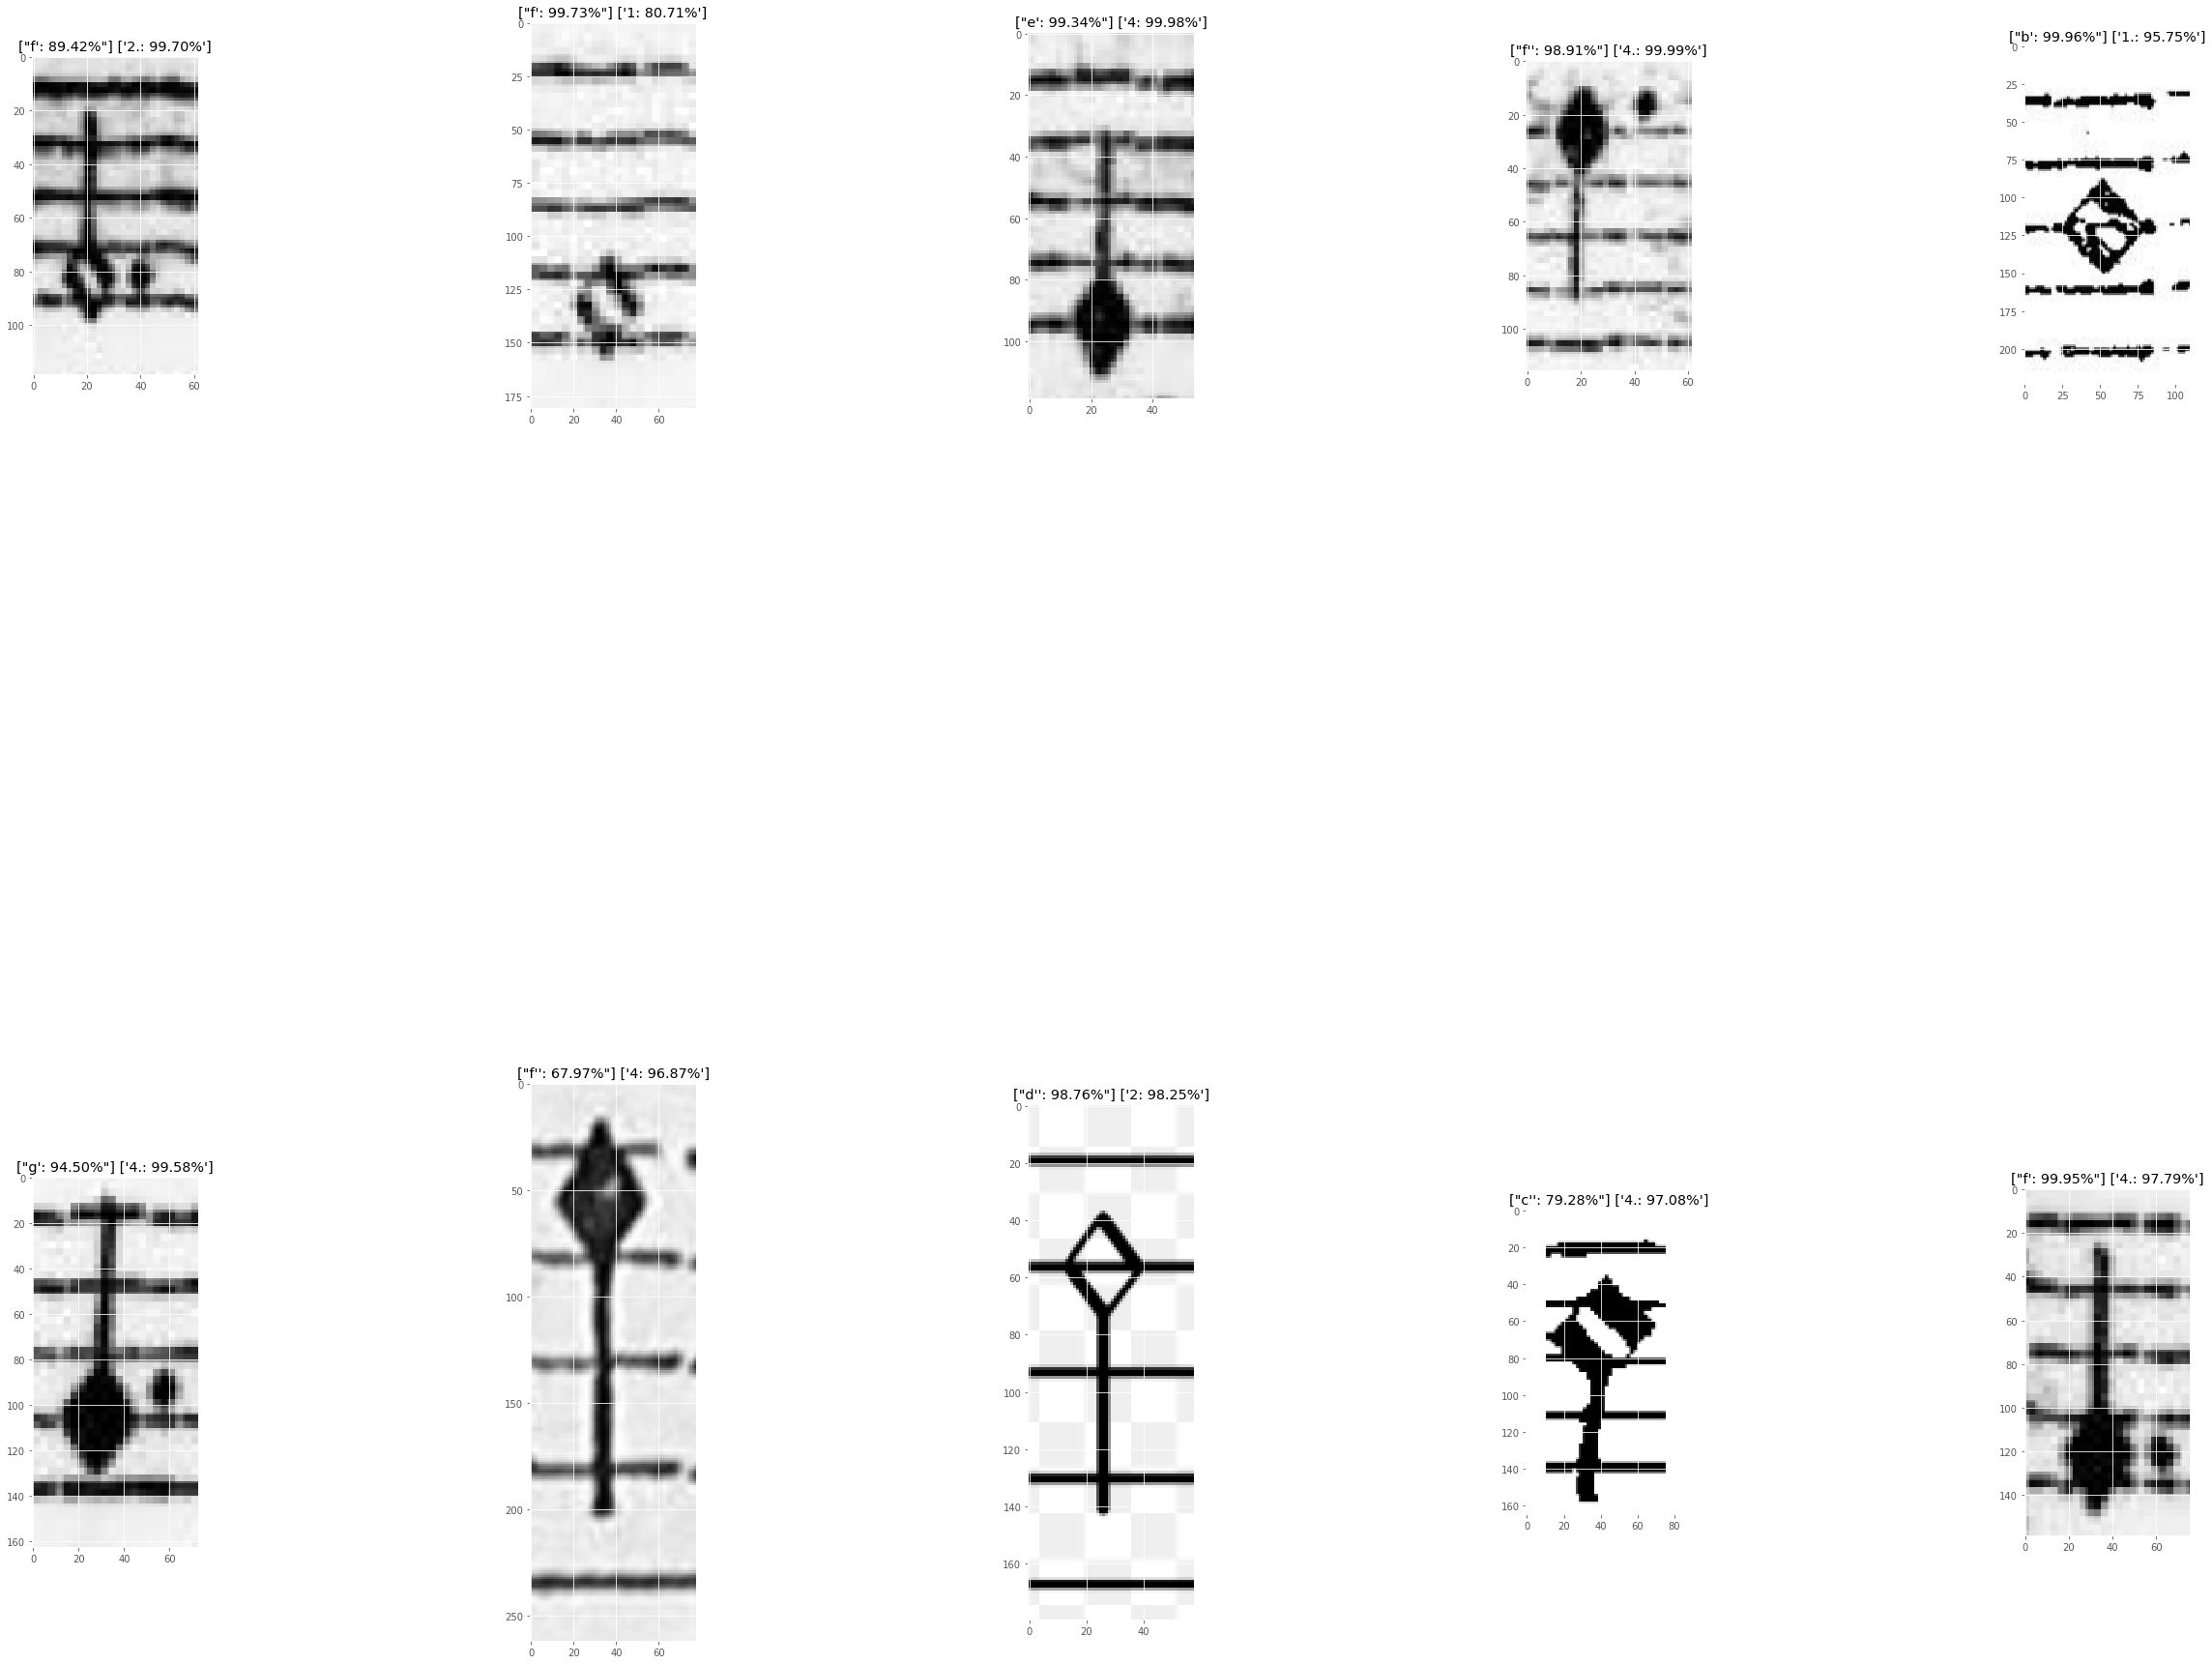

In [61]:
##### See which notes with labels

IMAGE_DIMS = (158, 100, 1)
plt.figure(figsize=[40,40]) # set image size
plt.subplots_adjust(wspace = 2)# set distance between the subplots

folder = "/Users/annaleid/Documents/Jordy/test images/"
images = os.listdir(folder)
i = 0

for image in images[:10]:
    plt.subplot(2,5,i+1)
    picture = cv2.imread(folder+image, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(picture, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    ret1, th1 = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    im = img_to_array(im)
    im = np.expand_dims(im, axis=0)
    
    [note_proba, duration_proba] = model.predict(im)
    note_proba = note_proba[0]
    duration_proba = duration_proba[0]
    noteIdxs = np.argsort(note_proba)[::-1][:1]
    durationIdxs = np.argsort(duration_proba)[::-1][:1]
    note_label = ["{}: {:.2f}%".format(noteLB.classes_[x], note_proba[x] * 100) for x in noteIdxs]
    duration_label = ["{}: {:.2f}%".format(durationLB.classes_[x], duration_proba[x] * 100) for x in durationIdxs]
    plt.title('{} {}'.format(note_label, duration_label))
    
    i+=1
    im.shape
    imgplot = plt.imshow(picture, cmap='gray')
    
plt.show()